### **Ejercicio 1**  
Dado el grafo de cómputo de la imagen siguiente (imagen: ejercicio1-grafo.jpeg), donde a=1, b=2 y c=3:
Realizar el paso forward y calcular Y.  
Realizar el paso backward y calcular el backpropagation para a,b y c:  
**a.** En forma analítica (dy/dx = 0).  
**b.** Utilizando pytorch.  
**c.** Comparar los resultados de los puntos anteriores.

In [1]:
import torch

Variables iniciales.

In [2]:
a = torch.tensor(1., requires_grad=True)
b = torch.tensor(2., requires_grad=True)
c = torch.tensor(3., requires_grad=True)

Pas forward.

In [3]:
d = a + b
e = b - c
Y = d * e

In [4]:
print(f"Valor de Y: {Y.item()}")

Valor de Y: -3.0


Paso backward.

In [5]:
Y.backward()

Obtener los Gradientes.

In [7]:
grad_a = a.grad
grad_b = b.grad
grad_c = c.grad

print(f"Gradiente de Y con respecto a a: {grad_a.item()}")
print(f"Gradiente de Y con respecto a b: {grad_b.item()}")
print(f"Gradiente de Y con respecto a c: {grad_c.item()}")

Gradiente de Y con respecto a a: -1.0
Gradiente de Y con respecto a b: 2.0
Gradiente de Y con respecto a c: -3.0


Resultados analíticos.

In [8]:
analytical_grad_a = b - c
analytical_grad_b = (b - c) + (a + b)
analytical_grad_c = -(a + b)

print(f"Gradiente analítico de Y con respecto a a: {analytical_grad_a}")
print(f"Gradiente analítico de Y con respecto a b: {analytical_grad_b}")
print(f"Gradiente analítico de Y con respecto a c: {analytical_grad_c}")

Gradiente analítico de Y con respecto a a: -1.0
Gradiente analítico de Y con respecto a b: 2.0
Gradiente analítico de Y con respecto a c: -3.0


Comparación de resultados.

In [9]:
print("Comparación de resultados:")
print(f"a - PyTorch: {grad_a.item()}, \tAnalítico: {analytical_grad_a}.")
print(f"b - PyTorch: {grad_b.item()}, \tAnalítico: {analytical_grad_b}.")
print(f"c - PyTorch: {grad_c.item()}, \tAnalítico: {analytical_grad_c}.")


Comparación de resultados:
a - PyTorch: -1.0, 	Analítico: -1.0.
b - PyTorch: 2.0, 	Analítico: 2.0.
c - PyTorch: -3.0, 	Analítico: -3.0.


### **Ejercicio 2.**  
Se desea construir un sistema de recomendación de películas. Para esto se cuenta con un dataset de las puntuaciones que los usuarios han asignado a las peliculas disponibles.  

Link dataset: https://drive.google.com/file/d/1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar/view?usp=sharing  

Para verificar la factibilidad del proyecto con datos válidos, se decide utilizar solamente las 200 películas con más votos y los usuarios que han puntuado al menos 100 películas.  

**1.** Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.  

**2.** A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula.  

**3.** Elegir un usuario al azar, una película que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con el puntaje real que el usuario asignó a dicha película.  

**4.** Realizar una recomendación de película para el usuario del punto 3 utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.  

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [23]:
# Descargar el dataset.
# !wget -O ratings.csv 'https://drive.google.com/uc?export=download&id=1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar'

In [2]:
ratings = pd.read_csv('./ratings.csv')

**1.** Filtrar las 200 películas con más votos y los usuarios que hayan votado al menos 100 películas.

In [3]:
movie_counts = ratings['movieId'].value_counts()
top_200_movies = movie_counts.head(200).index
filtered_ratings = ratings[ratings['movieId'].isin(top_200_movies)]

user_counts = filtered_ratings['userId'].value_counts()
active_users = user_counts[user_counts >= 100].index
filtered_ratings = filtered_ratings[filtered_ratings['userId'].isin(active_users)]

Codificar usuarios y películas.

In [6]:
user_id_map = {id: idx for idx, id in enumerate(filtered_ratings['userId'].unique())}
movie_id_map = {id: idx for idx, id in enumerate(filtered_ratings['movieId'].unique())}

filtered_ratings['userId'] = filtered_ratings['userId'].map(user_id_map)
filtered_ratings['movieId'] = filtered_ratings['movieId'].map(movie_id_map)

**2.** Construcción de la red neuronal.

In [40]:
# class RecommenderNet(nn.Module):
#     def __init__(self, num_users, num_movies, embedding_size=50):
#         super(RecommenderNet, self).__init__()
#         self.user_embedding = nn.Embedding(num_users, embedding_size)
#         self.movie_embedding = nn.Embedding(num_movies, embedding_size)
#         self.fc1 = nn.Linear(embedding_size * 2, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 1)

#     def forward(self, user_id, movie_id):
#         user_embedding = self.user_embedding(user_id)
#         movie_embedding = self.movie_embedding(movie_id)
#         x = torch.cat([user_embedding, movie_embedding], dim=1)
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [4]:
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Definir la red neuronal
class ComplexRecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
    
    def forward(self, user_ids, movie_ids):
        user_embedding = self.user_embedding(user_ids)
        movie_embedding = self.movie_embedding(movie_ids)
        x = torch.cat([user_embedding, movie_embedding], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [7]:
# Crear el modelo
num_users = len(user_id_map)
num_movies = len(movie_id_map)
embedding_size = 50
model = ComplexRecommenderNet(num_users, num_movies, embedding_size)

In [8]:
# Crear el conjunto de datos y el cargador de datos
train_data, test_data = train_test_split(filtered_ratings, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(train_data['userId'].values, dtype=torch.int64), 
                              torch.tensor(train_data['movieId'].values, dtype=torch.int64), 
                              torch.tensor(train_data['rating'].values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [9]:
# Crear el optimizador y la función de pérdida
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [17]:
# Entrenar el modelo
epochs = 50
for epoch in range(epochs):
    model.train()
    for user_ids, movie_ids, ratings in train_loader:
        optimizer.zero_grad()
        outputs = model(user_ids, movie_ids).squeeze()
        loss = loss_fn(outputs, ratings)
        loss.backward()
        optimizer.step()

In [35]:
# Elegir un usuario al azar
random_user = torch.randint(0, num_users, (1,)).item()

# Elegir una película que el usuario haya calificado
user_ratings = train_data[train_data['userId'] == random_user]
random_movie = user_ratings.sample(1)['movieId'].values[0]

# Verificar la predicción del modelo
model.eval()
with torch.no_grad():
    predicted_rating = model(torch.tensor([random_user]), torch.tensor([random_movie])).item()

# Obtener el puntaje real que el usuario asignó a la película
actual_rating = user_ratings[user_ratings['movieId'] == random_movie]['rating'].values[0]

print(f'Actual rating: {actual_rating}, Predicted rating: {predicted_rating}')

Actual rating: 3.0, Predicted rating: 2.720954418182373


In [37]:
import numpy as np

# Calcular el producto punto entre el embedding del usuario y todos los embeddings de las películas
user_embedding = model.user_embedding(torch.tensor([random_user]))
movie_scores = torch.mm(user_embedding, model.movie_embedding.weight.t()).squeeze()

# Obtener las películas que el usuario ya ha calificado
rated_movies = train_data[train_data['userId'] == random_user]['movieId'].values

# Eliminar las películas ya calificadas de las recomendaciones
movie_scores[rated_movies] = -np.inf

# Elegir la película con el mayor producto punto
recommended_movie = movie_scores.argmax().item()

# Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal
with torch.no_grad():
    predicted_rating = model(torch.tensor([random_user]), torch.tensor([recommended_movie])).item()

print(f'Recommended movie: {recommended_movie}, Predicted rating: {predicted_rating}')

Recommended movie: 177, Predicted rating: 3.14564847946167


In [14]:
num_users = len(user_id_map)
num_movies = len(movie_id_map)

In [ ]:
# model = RecommenderNet(num_users, num_movies)

In [15]:
loss_fn = nn.MSELoss()

In [41]:
# optimizer = optim.Adam(model.parameters(), lr=0.001)

Preparar los datos.

In [42]:
train_data, test_data = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

train_user_ids = torch.tensor(train_data['userId'].values, dtype=torch.int64)
train_movie_ids = torch.tensor(train_data['movieId'].values, dtype=torch.int64)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

test_user_ids = torch.tensor(test_data['userId'].values, dtype=torch.int64)
test_movie_ids = torch.tensor(test_data['movieId'].values, dtype=torch.int64)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)

In [16]:
# from sklearn.model_selection import train_test_split

# # Primero dividimos los datos en conjuntos de entrenamiento y prueba
# train_data, test_data = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

# # Luego dividimos el conjunto de entrenamiento en conjuntos de entrenamiento y validación
# train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

# # Ahora creamos los tensores para el conjunto de entrenamiento
# train_user_ids = torch.tensor(train_data['userId'].values, dtype=torch.int64)
# train_movie_ids = torch.tensor(train_data['movieId'].values, dtype=torch.int64)
# train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

# # Creamos los tensores para el conjunto de validación
# valid_user_ids = torch.tensor(valid_data['userId'].values, dtype=torch.int64)
# valid_movie_ids = torch.tensor(valid_data['movieId'].values, dtype=torch.int64)
# valid_ratings = torch.tensor(valid_data['rating'].values, dtype=torch.float32)

# # Finalmente, creamos los tensores para el conjunto de prueba
# test_user_ids = torch.tensor(test_data['userId'].values, dtype=torch.int64)
# test_movie_ids = torch.tensor(test_data['movieId'].values, dtype=torch.int64)
# test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)

Entrenamiento del modelo.

In [25]:
# epochs = 50
# embedding_size = 100

# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# model = RecommenderNet(num_users, num_movies, embedding_size)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)

# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(train_user_ids, train_movie_ids).squeeze()
#     loss = loss_fn(outputs, train_ratings)
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

**3.** Verificación de la predicción.

In [63]:
# import random

# model.eval()
# with torch.no_grad():
#     random_user = random.choice(test_data['userId'].unique())
#     user_data = test_data[test_data['userId'] == random_user]
#     random_movie = user_data.sample(1)
#     random_movie_id = torch.tensor(random_movie['movieId'].values[0], dtype=torch.int64)
#     actual_rating = random_movie['rating'].values[0]

#     user_tensor = torch.tensor([random_user], dtype=torch.int64)
#     movie_tensor = torch.tensor([random_movie_id])
    
#     predicted_rating = model(user_tensor, movie_tensor).item()
#     print(f'Actual rating: {actual_rating}, Predicted rating: {predicted_rating}')

Actual rating: 4.0, Predicted rating: 2.8576090335845947


**4.** Realización de una recomendación.

In [45]:
# with torch.no_grad():
#     user_embedding = model.user_embedding(torch.tensor([random_user], dtype=torch.int64))
#     movie_embeddings = model.movie_embedding.weight
#     scores = torch.matmul(user_embedding, movie_embeddings.t()).squeeze()
#     recommended_movie_id = torch.argmax(scores).item()

#     recommended_movie_actual_rating = test_data[(test_data['userId'] == random_user) & (test_data['movieId'] == recommended_movie_id)]['rating']
    
#     if not recommended_movie_actual_rating.empty:
#         recommended_movie_actual_rating = recommended_movie_actual_rating.values[0]
#         print(f'Recommended movie ID: {recommended_movie_id}, Actual rating: {recommended_movie_actual_rating}')
#     else:
#         print(f'Recommended movie ID: {recommended_movie_id} has not been rated by the user.')


Recommended movie ID: 68 has not been rated by the user.


In [45]:
# import pandas as pd
# import torch
# from torch import nn, optim
# from torch.utils.data import TensorDataset, DataLoader
# import torch.nn.functional as F
# import numpy as np

# # # 1. Analizar el dataset
# # data = pd.read_csv('ratings.csv')

# # # Filtrar las 200 películas con más votos
# # top_movies = data['movieId'].value_counts()[:200].index
# # data = data[data['movieId'].isin(top_movies)]

# # # Filtrar los usuarios que han puntuado al menos 100 películas
# # active_users = data['userId'].value_counts()
# # active_users = active_users[active_users >= 100].index
# # data = data[data['userId'].isin(active_users)]

# # # Mapear los ID de usuario y película a valores enteros consecutivos
# # user_ids = data['userId'].unique()
# # user2user_encoded = {x: i for i, x in enumerate(user_ids)}
# # user_encoded2user = {i: x for i, x in enumerate(user_ids)}

# movie_ids = ratings['movieId'].unique()
# # movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
# movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

# # data['user'] = data['userId'].map(user2user_encoded)
# # data['movie'] = data['movieId'].map(movie2movie_encoded)

# # num_users = len(user2user_encoded)
# # num_movies = len(movie_encoded2movie)
# embedding_size = 50

# # 2. Construir la red neuronal
# class ComplexRecommenderNet(nn.Module):
#     def __init__(self, num_users, num_movies, embedding_size):
#         super().__init__()
#         self.user_embedding = nn.Embedding(num_users, embedding_size)
#         self.movie_embedding = nn.Embedding(num_movies, embedding_size)
#         self.fc1 = nn.Linear(embedding_size * 2, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.output = nn.Linear(64, 1)
    
#     def forward(self, user_ids, movie_ids):
#         user_embedding = self.user_embedding(user_ids)
#         movie_embedding = self.movie_embedding(movie_ids)
#         x = torch.cat([user_embedding, movie_embedding], dim=1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return self.output(x)

# model = ComplexRecommenderNet(num_users, num_movies, embedding_size)

# # 3. Entrenar el modelo
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# loss_fn = nn.MSELoss()

# epochs = 50
# batch_size = 256
# train_dataset = TensorDataset(torch.tensor(ratings['user'].values, dtype=torch.int64), 
#                               torch.tensor(ratings['movie'].values, dtype=torch.int64), 
#                               torch.tensor(ratings['rating'].values, dtype=torch.float32))
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# for epoch in range(epochs):
#     model.train()
#     for user_ids, movie_ids, ratings in train_loader:
#         optimizer.zero_grad()
#         outputs = model(user_ids, movie_ids).squeeze()
#         loss = loss_fn(outputs, ratings)
#         loss.backward()
#         optimizer.step()
#     scheduler.step()

IndexError: too many indices for tensor of dimension 1

In [44]:
# 4. Realizar una recomendación
random_user = np.random.choice(ratings['user'].unique())
random_movie = np.random.choice(ratings['movie'].unique())
with torch.no_grad():
    predicted_rating = model(torch.tensor([random_user], dtype=torch.int64), torch.tensor([random_movie], dtype=torch.int64)).item()

    actual_rating = ratings[(ratings['user'] == random_user) & (ratings['movie'] == random_movie)]['rating']
    if not actual_rating.empty:
        actual_rating = actual_rating.values[0]
        print(f'Actual rating: {actual_rating}, Predicted rating: {predicted_rating}')
    else:
        print(f'The user has not rated the movie. Predicted rating: {predicted_rating}')

The user has not rated the movie. Predicted rating: 4.160890102386475


In [104]:
# 4. Realizar una recomendación
# random_user = np.random.choice(data['user'].unique())

# Obtén el embedding del usuario
user_embedding = model.user_embedding(torch.tensor([random_user], dtype=torch.int64))

# Calcula el producto punto entre el embedding del usuario y todos los embeddings de las películas
movie_scores = torch.mm(user_embedding, model.movie_embedding.weight.t()).squeeze()

# Obtiene las películas que el usuario ya ha calificado
rated_movies = ratings[ratings['user'] == random_user]['movie'].values

# Elimina las películas ya calificadas de las recomendaciones
movie_scores[rated_movies] = -np.inf

# Elige la película con el mayor producto punto
recommended_movie = movie_scores.argmax().item()

# Comprueba si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal
with torch.no_grad():
    predicted_rating = model(torch.tensor([random_user], dtype=torch.int64), torch.tensor([recommended_movie], dtype=torch.int64)).item()

print(f'Recommended movie: {movie_encoded2movie[recommended_movie]}, Predicted rating: {predicted_rating}')

Recommended movie: 44191, Predicted rating: 4.263331890106201


Epoch 0, Train Loss: 1.3123300075531006, Valid Loss: 14.206058661142984
Epoch 1, Train Loss: 14.449224472045898, Valid Loss: 14.157542705535889
Epoch 2, Train Loss: 14.082127571105957, Valid Loss: 14.244159857432047
Epoch 3, Train Loss: 14.737516403198242, Valid Loss: 14.055394331614176
Epoch 4, Train Loss: 13.309220314025879, Valid Loss: 14.19288428624471
Epoch 5, Train Loss: 14.349536895751953, Valid Loss: 14.147050221761068
Epoch 6, Train Loss: 14.00273609161377, Valid Loss: 14.254459222157797
Epoch 7, Train Loss: 14.815444946289062, Valid Loss: 14.218339125315348
Epoch 8, Train Loss: 14.542141914367676, Valid Loss: 14.183543682098389
Epoch 9, Train Loss: 14.278863906860352, Valid Loss: 14.1569717725118
Epoch 10, Train Loss: 14.077807426452637, Valid Loss: 14.32325267791748
Epoch 11, Train Loss: 15.335970878601074, Valid Loss: 14.096497058868408
Epoch 12, Train Loss: 13.620226860046387, Valid Loss: 14.236373583475748
Epoch 13, Train Loss: 14.678601264953613, Valid Loss: 14.095616181

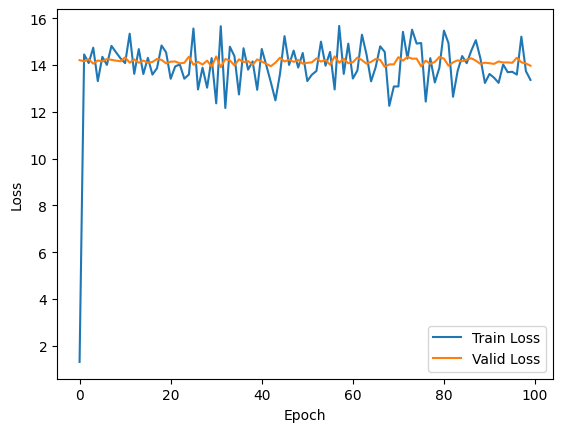

In [64]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

epochs = 100
embedding_size = 100

# Aumentar la complejidad del modelo
class ComplexRecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
    
    def forward(self, user_ids, movie_ids):
        user_embedding = self.user_embedding(user_ids)
        movie_embedding = self.movie_embedding(movie_ids)
        x = torch.cat([user_embedding, movie_embedding], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

model = ComplexRecommenderNet(num_users, num_movies, embedding_size)

# Usar un optimizador diferente
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Ajustar el tamaño del lote
batch_size = 256
train_dataset = TensorDataset(train_user_ids, train_movie_ids, train_ratings)
valid_dataset = TensorDataset(valid_user_ids, valid_movie_ids, valid_ratings)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Usar una programación de la tasa de aprendizaje
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Asumiendo que tienes un conjunto de validación
valid_dataset = TensorDataset(valid_user_ids, valid_movie_ids, valid_ratings)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_epoch_losses = []
    for user_ids, movie_ids, ratings in train_loader:
        # Tu código de entrenamiento aquí
        train_epoch_losses.append(loss.item())
    train_epoch_loss = sum(train_epoch_losses) / len(train_epoch_losses)
    train_losses.append(train_epoch_loss)

    model.eval()
    valid_epoch_losses = []
    with torch.no_grad():
        for user_ids, movie_ids, ratings in valid_loader:
            outputs = model(user_ids, movie_ids).squeeze()
            loss = loss_fn(outputs, ratings)
            valid_epoch_losses.append(loss.item())
    valid_epoch_loss = sum(valid_epoch_losses) / len(valid_epoch_losses)
    valid_losses.append(valid_epoch_loss)

    print(f'Epoch {epoch}, Train Loss: {train_epoch_loss}, Valid Loss: {valid_epoch_loss}')

# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [75]:
# Seleccionar un usuario y una película al azar del conjunto de datos de entrenamiento
random_index = torch.randint(0, len(train_dataset), (1,)).item()
random_user, random_movie, actual_rating = train_dataset[random_index]

# Usar el modelo para predecir la calificación
model.eval()
with torch.no_grad():
    predicted_rating = model(random_user.unsqueeze(0), random_movie.unsqueeze(0)).item()

print(f'User ID: {random_user.item()}, Movie ID: {random_movie.item()}')
print(f'Actual rating: {actual_rating.item()}, Predicted rating: {predicted_rating}')

User ID: 50, Movie ID: 0
Actual rating: 4.0, Predicted rating: 4.23982572555542


In [71]:
# Obtener el embedding del usuario seleccionado
user_embedding = model.user_embedding(random_user.unsqueeze(0))

# Calcular el producto escalar de este embedding de usuario con todos los embeddings de película
movie_scores = torch.mm(user_embedding, model.movie_embedding.weight.t()).squeeze()

# Obtener las películas que el usuario ya ha calificado
rated_movies = train_dataset.tensors[1][train_dataset.tensors[0] == random_user]

# Encontrar la película con la puntuación más alta que el usuario aún no ha calificado
recommended_movie = None
for movie_id, score in enumerate(movie_scores):
    if movie_id not in rated_movies and (recommended_movie is None or score > movie_scores[recommended_movie]):
        recommended_movie = movie_id

print(f'Recommended Movie ID: {recommended_movie}')

# Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal
with torch.no_grad():
    predicted_rating = model(random_user.unsqueeze(0), torch.tensor([recommended_movie])).item()

print(f'Predicted rating for recommended movie: {predicted_rating}')

AttributeError: 'numpy.int64' object has no attribute 'unsqueeze'